In [1]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

RS = 40

## 8

In [2]:
from sklearn import datasets
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, centers=2, n_features=2,
                  random_state=RS)

In [3]:
y

array([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0])

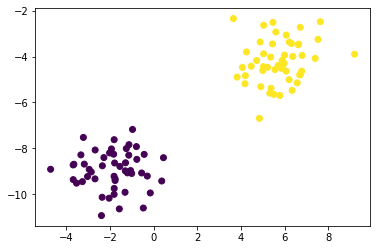

In [4]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.show();

In [5]:
C = 1

lin = LinearSVC(loss="hinge", C=C, random_state=RS)
svm = SVC(kernel="linear", C=C)
sgd = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=0.0001, random_state=RS)

scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
X_scaled = X

lin.fit(X_scaled, y)
svm.fit(X_scaled, y)
sgd.fit(X_scaled, y);

In [6]:
print(lin.intercept_, lin.coef_)
print(svm.intercept_, svm.coef_)
print(sgd.intercept_, sgd.coef_)

[0.03511623] [[0.44024239 0.14653795]]
[0.62121467] [[0.37171646 0.21268493]]
[0.021] [[0.40970577 0.13791457]]


In [7]:
lin.coef_[0]

array([0.44024239, 0.14653795])

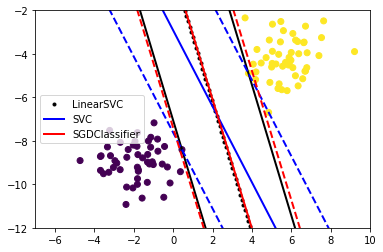

In [8]:
def plot_decision_boundary(clf, xmin=-6, xmax=10, col=["k.", "k"], label=""):
    w = clf.coef_[0]
    b = clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # Ax+By+C=0-> By=-Ax-C -> y=-Ax/B - C/B
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    plt.plot(x0, decision_boundary, col[0], linewidth=2, label=label)
    plt.plot(x0, gutter_up, col[1], linewidth=2)
    plt.plot(x0, gutter_down, col[1], linewidth=2)

plot_decision_boundary(lin, label="LinearSVC")
plot_decision_boundary(svm, col=["b-", "b--"], label="SVC")
plot_decision_boundary(sgd, col=["r-", "r--"], label="SGDClassifier")
plt.scatter(X[:,0], X[:,1], c=y)
# plt.ylim([-12,-1])
plt.legend()
plt.axis([-7, 10, -12, -2])
plt.show();

## 9

In [9]:
# Извлекаем данные
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

X = mnist["data"]
y = mnist["target"]

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [10]:
# разбиваем датасет и нормируем
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [11]:
%%time
# обучаем классификатор
lin_2 = LinearSVC(random_state=RS)
lin_2.fit(X_train_scaled, y_train)

/home/admin1/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=40, tol=0.0001,
          verbose=0)

In [12]:
from sklearn.metrics import accuracy_score
# считаем accuracy
y_pred = lin_2.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9007142857142857

In [13]:
# обучаем другой классификатор на части train
svm_2 = SVC(decision_function_shape="ovr", gamma="auto")
svm_2.fit(X_train_scaled[:10000], y_train[:10000])
# считаем accuracy для train
y_pred = svm_2.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9472142857142857

In [14]:
y_pred = svm_2.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9377857142857143

In [17]:
from sklearn.model_selection import RandomizedSearchCV
# ищем лучшие параметры
param_distributions = {"gamma": [0.001, 0.01, 0.1], "C": [0.1, 1, 5, 10]}
rnd_search_cv = RandomizedSearchCV(svm_2, param_distributions, n_iter=5, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] gamma=0.001, C=10 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ gamma=0.001, C=10, total=   0.6s
[CV] gamma=0.001, C=10 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ................................ gamma=0.001, C=10, total=   0.7s
[CV] gamma=0.001, C=10 ...............................................
[CV] ................................ gamma=0.001, C=10, total=   0.7s
[CV] gamma=0.1, C=1 ..................................................
[CV] ................................... gamma=0.1, C=1, total=   1.0s
[CV] gamma=0.1, C=1 ..................................................
[CV] ................................... gamma=0.1, C=1, total=   1.1s
[CV] gamma=0.1, C=1 ..................................................
[CV] ................................... gamma=0.1, C=1, total=   1.0s
[CV] gamma=0.1, C=10 .................................................
[CV] .................................. gamma=0.1, C=10, total=   1.0s
[CV] gamma=0.1, C=10 .................................................
[CV] .................................. gamma=0.1, C=10, total=   1.0s
[CV] gamma=0.1, C=10 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   14.1s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='auto', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=5, n_jobs=None,
                   param_distributions={'C': [0.1, 1, 5, 10],
                                        'gamma': [0.001, 0.01, 0.1]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [19]:
# обучаем лучший оценщик
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)


In [20]:
accuracy_score(y_train, y_pred)

0.9983392857142858

In [21]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
# считаем accuracy для test
accuracy_score(y_test, y_pred)

0.9718571428571429